In [2]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from quantum_utils import quantum_optics_utils as qou

from mpl_toolkits.mplot3d.axes3d import Axes3D
from math_utils import statistics_utils as su

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>


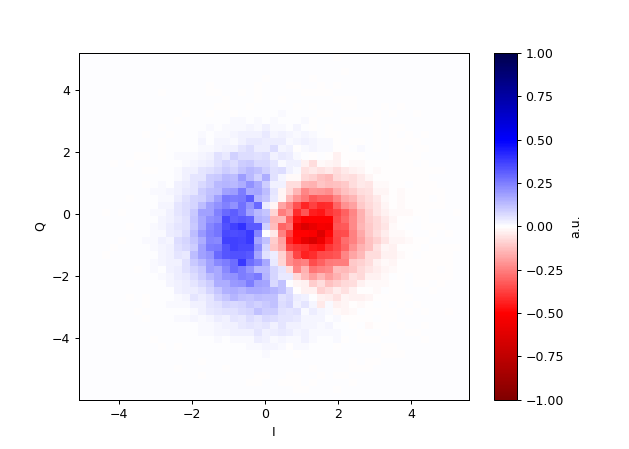

In [4]:
# 1.5 pi pulse data
pi = np.pi
scale = np.sqrt(1.0342936424547473)

path = "/Users/andreas/Desktop/work/cluster_state/photon_tomography/measurement_data/"
f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_0.5pi_5times_real.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_0.5pi_5times_imag.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_p1 = (data_real_all + 1j*data_imag_all)
shots_all_p1 = scale * shots_all_p1
f_real.close(); f_imag.close()

f_real = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_0.5pi_5times_real_dark.txt'))
f_imag = open(os.path.join(path, 'Q3_278.22mV_field_singleshot_0.5pi_5times_imag_dark.txt'))
data_real = f_real.readlines()
data_imag = f_imag.readlines()
data_real_all = np.array( [np.array([float(val) for val in data_real[i].split('\t')]) for i in range(4,9)]).flatten()
data_imag_all = np.array( [np.array([float(val) for val in data_imag[i].split('\t')]) for i in range(4,9)]).flatten()
shots_all_dark = (data_real_all + 1j*data_imag_all)
shots_all_dark = scale * shots_all_dark
f_real.close(); f_imag.close()

hist_2D_p1 = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), bins = 50, density = True)
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[hist_2D_p1[1][0], hist_2D_p1[1][-1]], [hist_2D_p1[2][0], hist_2D_p1[2][-1]]],
                                 bins = 50, density = True)
dI_dQ = (hist_2D_p1[1][0] - hist_2D_p1[1][-1])*(hist_2D_p1[2][0] - hist_2D_p1[2][-1])/2500

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
yy, xx = np.meshgrid(hist_2D_p1[1][:-1], hist_2D_p1[2][:-1])
pcolor = ax.pcolormesh(xx, yy, (hist_2D_p1[0] - hist_2D_dark[0])/dI_dQ, cmap='seismic_r')
fig.colorbar(pcolor, ax=ax, aspect = 15, label = "a.u.")
ax.set_xlabel('I'); ax.set_ylabel('Q') 
pcolor.set_clim(-1,1)

In [5]:
# Construct the scaled data
scaled_shots_all_dark = shots_all_dark / scale
scaled_shots_all_p1 = shots_all_p1 / scale

In [6]:
# Construct the ideal POVM for the noise reconstruction
max_x = 7.5
mesh_size = 0.5

# Define the range of dimensions
dim = 100

s = time.time()
ideal_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 8.978214025497437 seconds


In [7]:
# Make the scaled histograms
hist_2D_dark = np.histogram2d(np.real(shots_all_dark), np.imag(shots_all_dark), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

hist_2D = np.histogram2d(np.real(shots_all_p1), np.imag(shots_all_p1), 
                                 range = [[xs[0] - mesh_size/2, xs[-1] + mesh_size/2],[ps[0] - mesh_size/2, ps[-1] + mesh_size/2]],
                                 bins = len(xs), density = True)[0]

In [8]:
# Do the noise state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 300
s = time.time()
reconstructed_noise_state, noise_lls = \
    cst2.perform_coherent_state_MLE(
        ideal_povm,
        hist_2D_dark, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

Time for MLE reconstruction for dim = 100: 248.52636218070984 s


<IPython.core.display.Javascript object>


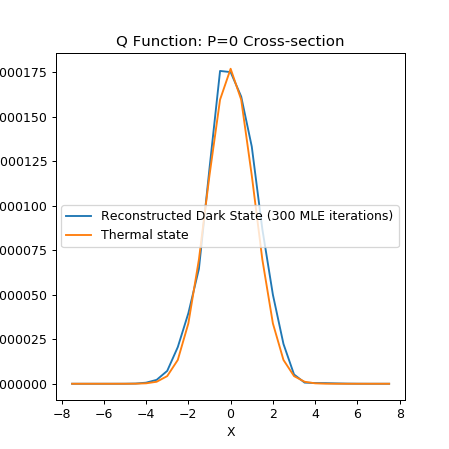

Text(0.5, 1.0, 'Q Function: P=0 Cross-section')

In [9]:
# Fit the noise state to get the noise photons
number_of_noise_photons = 1.42
ideal_noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
ideal_noisy_qfunc = qutip.qfunc(ideal_noise_state, xs, ps, g=2)
reconstructed_noisy_qfunc = qutip.qfunc(reconstructed_noise_state, xs, ps, g=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xs, reconstructed_noisy_qfunc[len(xs) // 4], label='Reconstructed Dark State (300 MLE iterations)')
ax.plot(xs, ideal_noisy_qfunc[len(xs) // 4], label='Thermal state')
ax.set_xlabel('X')
ax.set_ylabel('Q')
ax.legend()
ax.set_title('Q Function: P=0 Cross-section')

In [10]:
# Make the noisy POVM
# Construct the ideal POVM for the noise reconstruction
max_x = 7.5
mesh_size = 0.5

# Define the dimension
dim = 300
fit_number_of_noise_photons = number_of_noise_photons
high_dimensional_ideal_noise_state = qutip.thermal_dm(dim, fit_number_of_noise_photons)

s = time.time()
ideal_povm, alphas, xs, ps = cst2.generate_coherent_state_POVM(max_x, 
                                                              mesh_size, 
                                                              dim,
                                                              noise_base = high_dimensional_ideal_noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 205.68513894081116 seconds


In [18]:
# Pending 10000 + 8000

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 10000
s = time.time()
reconstructed_signal_state, signal_lls = \
    cst2.perform_coherent_state_MLE(
        ideal_povm,
        hist_2D, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 300: 11755.182341814041 s


<IPython.core.display.Javascript object>


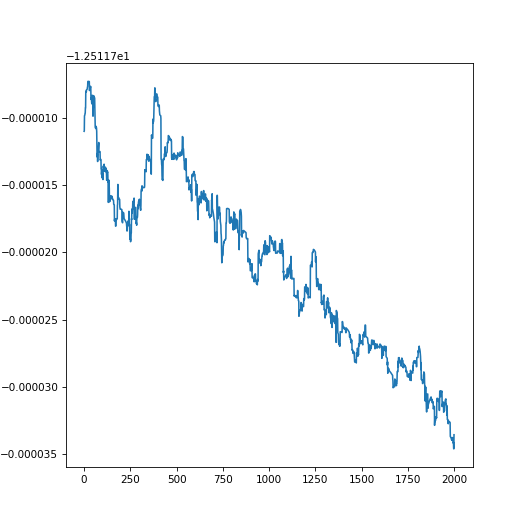

In [16]:
# Check convergence
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(signal_lls)

<IPython.core.display.Javascript object>


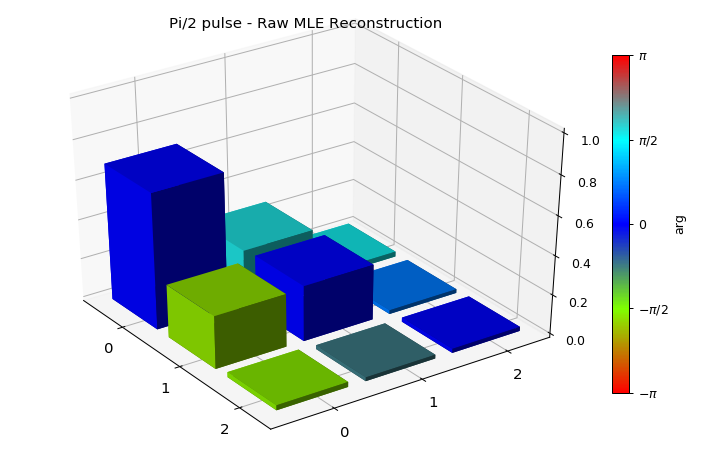

Text(0.5, 0.92, 'Pi/2 pulse - Raw MLE Reconstruction')

In [27]:
# Check to see if rho_00 = rho_11
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(reconstructed_signal_state,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)
ax.set_title('Pi/2 pulse - Raw MLE Reconstruction')

<IPython.core.display.Javascript object>


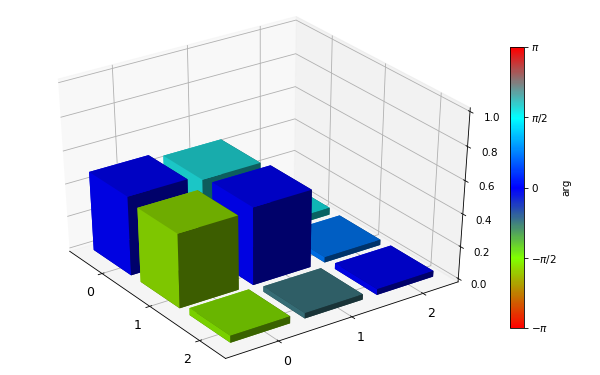

1.0000000000000002
(0.4832210014132988+0j)


In [20]:
# Correct for loss and plot
eta = 0.5971845023125946
vaccuum = qutip.basis(dim, 0) * qutip.basis(dim, 0).dag()
loss_corrected_reconstructed_state = (reconstructed_signal_state - (1 - eta)*vaccuum)
loss_corrected_reconstructed_state = loss_corrected_reconstructed_state / loss_corrected_reconstructed_state.tr()

lower_cutoff = 0
upper_cutoff = 2
windowed_loss_corrected_reconstructed_state = state_vis.windowed_density_matrix(loss_corrected_reconstructed_state,
                                                             lower_cutoff,
                                                             upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_loss_corrected_reconstructed_state)

print(loss_corrected_reconstructed_state.tr())
print(loss_corrected_reconstructed_state[0][0][0])

In [21]:
# SAVE POVM
povm_path = '/Users/andreas/Desktop/work/QuantumUtils/characterization_and_tomography/photonic_state_tomography/generated_data/povms/'
filename = 'dim_300_halfwidth_7p5_res_0p5_1p42_noise_photons.npz'
povm_savepath = os.path.join(povm_path, filename)
cst2.save_povm(povm_savepath, ideal_povm, alphas, xs, ps)

povms, new_alphas, new_xs, new_ps, new_noise_state = cst2.load_povm(povm_savepath)

# SAVE MLE RECONSTRUCTION
iter_path = "/Users/andreas/Desktop/work/QuantumUtils/characterization_and_tomography/photonic_state_tomography/generated_data/reconstruction_checkpoints/"
filename = '1_pi_half_reconstruction.npz'
iter_savepath = os.path.join(povm_path, filename)
iter_range = [8000, 18000]
rho0 = qutip.maximally_mixed_dm(dim)
cst2.save_reconstruction_iteration(iter_savepath,
                                   reconstructed_signal_state,
                                   hist_2D,
                                   signal_lls,
                                   alphas,
                                   xs,
                                   ps,
                                   iter_range,
                                   rho0,
                                   povm_savepath)

s, h, l, a, x, p, ir, r0, pp = cst2.load_reconstruction_iteration(iter_savepath)

<IPython.core.display.Javascript object>


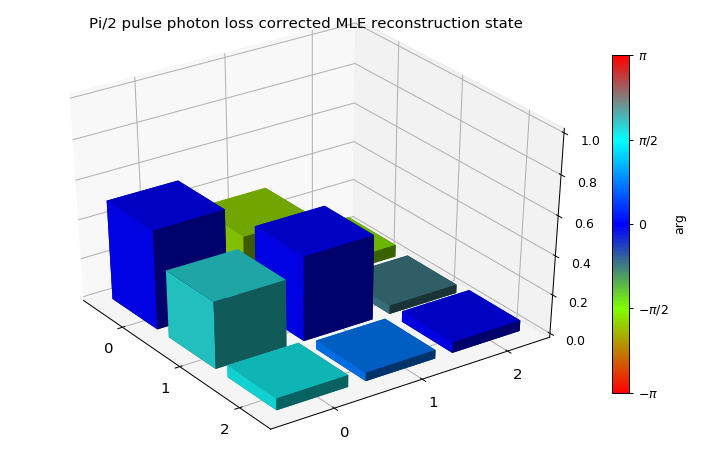

Text(0.5, 0.92, 'Pi/2 pulse photon loss corrected MLE reconstruction state')

In [26]:
max_lost_photons = 1
ir = cst2.inverse_bernoulli_transform(s, eta, max_lost_photons)

# Check to see if rho_00 = rho_11
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(ir,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)
ax.set_title('Pi/2 pulse photon loss corrected MLE reconstruction state')